In [1]:
print

<function print>

In [2]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import bubblewrap as bw
import bubblewrap.input_sources.functional as fin
import tqdm as tqdm
from bubblewrap.input_sources.data_sources import NumpyTimedDataSource
import bubblewrap.plotting_functions as bpf
import sklearn.decomposition
import pandas as pd

## Define Datasets

## Buzaki

In [4]:
obs, raw_behavior, bin_centers, beh_t = fin.construct_buzaki_data(base=fin.datasets["buzaki"][0], bin_size=0.03)

retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/buzaki_data_252347413985730.pickle


In [5]:
resampled_behavior = fin.resample_behavior(raw_behavior, bin_centers, beh_t)
hd = np.arctan2(resampled_behavior[:,0] - resampled_behavior[:,2], resampled_behavior[:,1] - resampled_behavior[:,3])
beh = resampled_behavior[:,:2]

In [6]:
pre_datasets = {
    's([obs,pos],6) # i': fin.prosvd_data(input_arr=np.hstack([obs, beh]), output_d=6, init_size=50),
    's(z([obs,pos]),4) # i': fin.prosvd_data(input_arr=fin.zscore(np.hstack([obs, beh])), output_d=4, init_size=50),
    's(obs,6) # i o': fin.prosvd_data(input_arr=obs, output_d=6, init_size=50),
    'pos # i o' : beh,
    

    'hd # o': hd.reshape(-1,1),
    # 'pca(obs,2) # i o' : sklearn.decomposition.PCA(n_components=2).fit_transform(obs),
}

for key, value in pre_datasets.items():
    pre_datasets[key] = fin.clip(value, beh_t)

retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/prosvd_data_982503923907197.pickle


100%|██████████| 745814/745814 [00:03<00:00, 202057.84it/s]


retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/prosvd_data_687428808301669.pickle
retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/prosvd_data_812143274770888.pickle


## Indy

In [3]:
obs, raw_behavior, bin_centers, beh_t = fin.construct_indy_data(fin.datasets["indy"][0])

In [5]:
resampled_behavior = fin.resample_behavior(raw_behavior, bin_centers, beh_t)
beh = resampled_behavior

In [18]:
pre_datasets = {
    's(obs,6) # i o': fin.prosvd_data(input_arr=obs, output_d=6, init_size=30),
    'beh # i o': beh,
    's([obs,beh],6) # i': fin.prosvd_data(input_arr=np.hstack([obs, beh]), output_d=6, init_size=20),
}

for key, value in pre_datasets.items():
    pre_datasets[key] = fin.clip(value, beh_t)

retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/prosvd_data_013393346625801.pickle
retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/prosvd_data_044205911604091.pickle


## Fly

In [131]:
obs, raw_behavior, obs_t, beh_t = fin.construct_fly_data(fin.datasets["fly"][0])

/home/jgould/miniconda3/envs/bw2/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/jgould/miniconda3/envs/bw2/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.3.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/jgould/miniconda3/envs/bw2/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [132]:
resampled_behavior = fin.resample_behavior(raw_behavior, obs_t, beh_t)
beh = resampled_behavior

In [133]:
pre_datasets = {
    's(obs,3) # i': fin.prosvd_data(input_arr=obs, output_d=3, init_size=30),
    's(z(obs),3) # i': fin.prosvd_data(input_arr=fin.zscore(obs, 10), output_d=3, init_size=30),
    's(obs,1) # o': fin.prosvd_data(input_arr=obs, output_d=1, init_size=30),
    # 'z(beh) # i': fin.zscore(beh, 10),
    's(z(beh),1) # o': fin.prosvd_data(input_arr=fin.zscore(beh, 10), output_d=1, init_size=20),
    's(z([obs,beh]),5) # i': fin.prosvd_data(input_arr=fin.zscore(np.hstack([obs, beh])), output_d=5, init_size=20),
    's(z([obs,beh]),1) # o': fin.prosvd_data(input_arr=fin.zscore(np.hstack([obs, beh])), output_d=1, init_size=20),
}

for key, value in pre_datasets.items():
    pre_datasets[key] = fin.clip(value, beh_t)

retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/prosvd_data_228423078208799.pickle


100%|██████████████████████████████████| 11671/11671 [00:00<00:00, 91360.40it/s]


retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/prosvd_data_895882024899689.pickle
retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/prosvd_data_561188369021184.pickle


100%|█████████████████████████████████| 11671/11671 [00:00<00:00, 211424.38it/s]


retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/prosvd_data_127001258086543.pickle


100%|██████████████████████████████████| 11671/11671 [00:00<00:00, 88282.90it/s]


retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/prosvd_data_435075322239975.pickle


100%|██████████████████████████████████| 11671/11671 [00:00<00:00, 91058.06it/s]


retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/prosvd_data_759406298300449.pickle


## Musal

In [5]:
ca, vid, t_ca, t_vid = fin.generate_musal_dataset(cam=1, video_target_dim=6, resize_factor=1, prosvd_init_size=100)

retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/generate_musal_dataset_254516486564245.pickle


In [6]:
resampled_vid = fin.resample_behavior(vid, t_ca, t_vid)

In [9]:
pre_datasets = {
    's(ca,6) # i o': fin.prosvd_data(input_arr=ca, output_d=6, init_size=30),
    's(vid,6) # i o': fin.prosvd_data(input_arr=resampled_vid, output_d=6, init_size=30),
    's([ca,s(vid,100)],6) # i': fin.prosvd_data(input_arr=np.hstack([ca, resampled_vid]), output_d=6, init_size=30),
}

for key, value in pre_datasets.items():
    pre_datasets[key] = fin.clip(value, t_ca)

retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/prosvd_data_291493993686594.pickle
retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/prosvd_data_922965903620119.pickle
retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/prosvd_data_445215430537049.pickle


## For all

In [7]:
with_randoms = {}
for key, value in pre_datasets.items():
    k = key.replace("🌀", "")
    with_randoms[k] = value
    if "🌀" in key:
        k, tags = k.split("#")
        k = k.strip()
        with_randoms[f"shuf({k}) #{tags.strip()}"] = (*fin.shuffle_time(value[0]), value[1])

datasets = {}
input_keys = []
output_keys = []
for key, value in with_randoms.items():
    k, tags = key.split("#")
    k = k.strip()
    datasets[k] = value
    assert np.all(np.isfinite(value[0]))
    if "i" in tags:
        input_keys.append(k)
    if "o" in tags:
        output_keys.append(k)

# Run Stuff

## Histograms

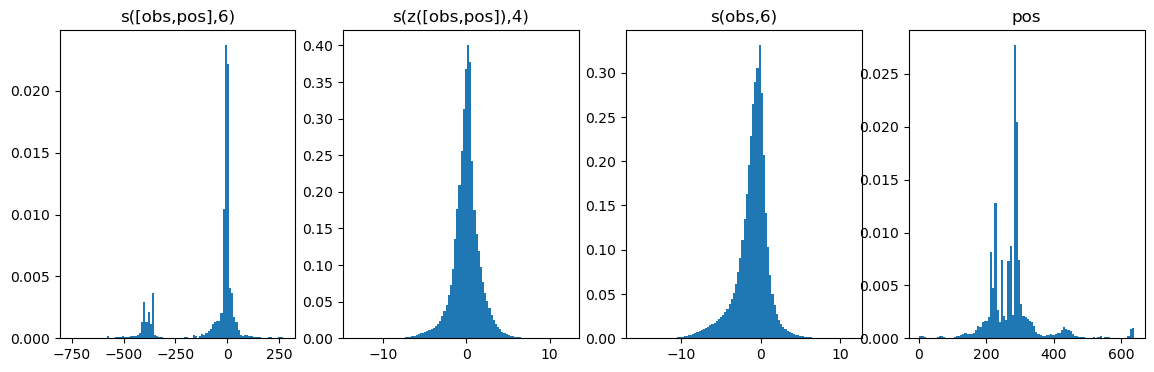

In [8]:
fig, ax = plt.subplots(ncols=len(input_keys), nrows=1, figsize=(14,4), squeeze=False)

for i, key in enumerate(input_keys):
    ax[0][i].hist(datasets[key][0].flatten(), bins=100, density=True)
    ax[0][i].set_title(key)

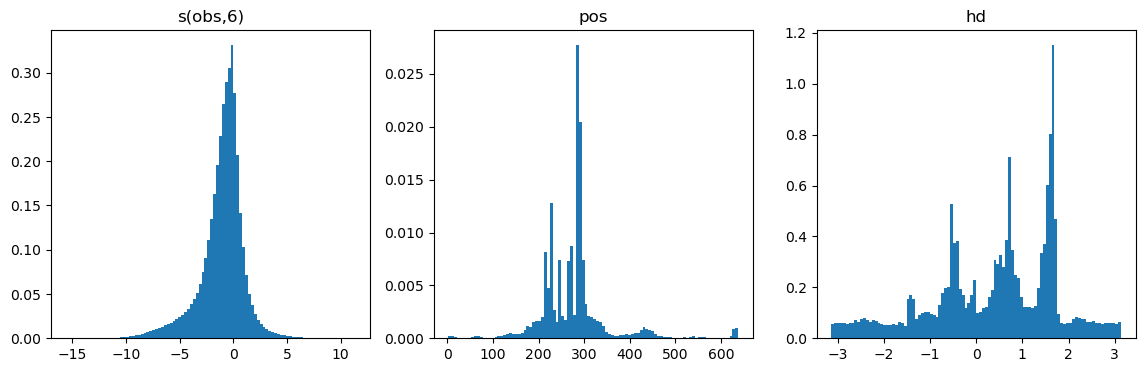

In [9]:
fig, ax = plt.subplots(ncols=len(output_keys), figsize=(14,4), squeeze=False)
for i, key in enumerate(output_keys):
    ax[0][i].hist(datasets[key][0].flatten(), bins=100, density=True)
    ax[0][i].set_title(key)

## Run Table

In [10]:
def evaluate(i,o, maxlen=30_000, bw_params=bw.default_parameters.default_jpca_dataset_parameters, seed=0):
    i, i_t, o, o_t = fin.clip(*i, *o, maxlen=maxlen)
    
    o_dt = np.median(np.diff(o_t))
    i_dt = np.median(np.diff(i_t))
    n_steps = int(np.ceil(o_dt/i_dt))
        
    br = bw.bw_run.simple_bw_run(input_arr=i,t=i_t, time_offsets=[0,n_steps], bw_params=bw_params)
    
    
    alpha_dict = br.alpha_history
    a_current, a_ahead, o, o_t = fin.clip(alpha_dict[0], alpha_dict[n_steps], o, o_t)
    reg = bw.regressions.SymmetricNoisyRegressor(input_d=a_current.shape[1], output_d=o.shape[1])
    
    pred, true, times = br.add_regressor_post_hoc(reg, o, o_t, test_offset=n_steps)
    return br, pred, true, times


In [ ]:
%%time
bw_params = dict(    
    bw.default_parameters.default_jpca_dataset_parameters, 
num=300,
eps=1e-8,
step=3,
num_grad_q=3,
)

results = {}
brs = {}
true_values = {}
for okey in output_keys:
    results[okey] = {}
    brs[okey] = {}
    true_values[okey] = {}
    for ikey in input_keys:
        print(f"{okey= } {ikey= }")
        
        br, pred, true, times = evaluate(datasets[ikey], datasets[okey], maxlen=5_000, bw_params=bw_params)
        
        results[okey][ikey] = pred
        brs[okey][ikey] = br
        true_values[okey][ikey] = (true, times)

okey= 's(obs,6)' ikey= 's([obs,pos],6)'
retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/simple_bw_run_196533203203989.pickle
okey= 's(obs,6)' ikey= 's(z([obs,pos]),4)'
retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/simple_bw_run_464261548948681.pickle
okey= 's(obs,6)' ikey= 's(obs,6)'
retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/simple_bw_run_079036066457239.pickle
okey= 's(obs,6)' ikey= 'pos'
retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/simple_bw_run_870041103910417.pickle
okey= 'pos' ikey= 's([obs,pos],6)'
retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/simple_bw_run_196533203203989.pickle
okey= 'pos' ikey= 's(z([obs,pos]),4)'
retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/simple_bw_run_464261548948681.pickle
okey= 'pos' ikey= 's(obs,6)'
retreiving cache from: /home/jgould/Do

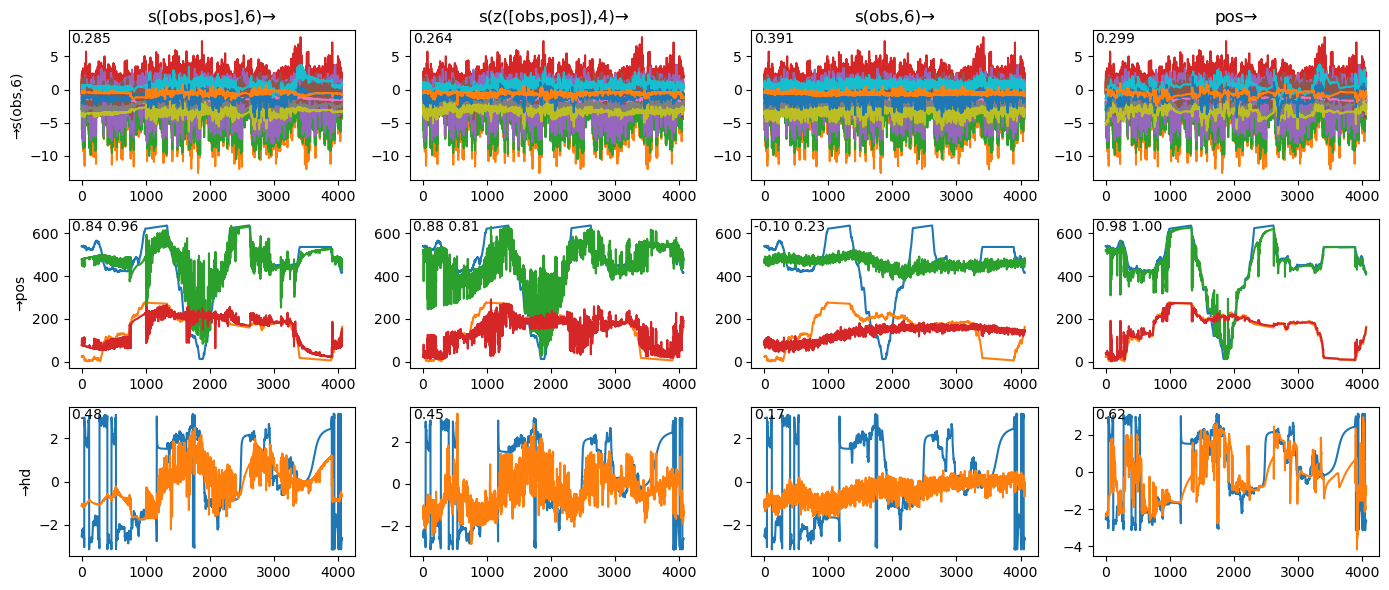

In [19]:
fig, ax = plt.subplots(nrows=len(output_keys), ncols=len(input_keys), figsize=(14,2*len(output_keys)), layout='tight', squeeze=False)

s = slice(-1)

for row, okey in enumerate(output_keys):
    ax[row,0].set_ylabel("→" + okey)
    for col, ikey in enumerate(input_keys):
        true, times, predicted = fin.clip(*true_values[okey][ikey], results[okey][ikey])
        # halfway = len(true)//2
        # corrs = [np.corrcoef(true[-halfway:,j], predicted[-halfway:,j])[0,1] for j in range(true.shape[1])]
        
        br = brs[okey][ikey]
        lh_predicted, lh_true, _ = br.get_behavior_last_half(br.obs_ds.time_offsets[-1])
        corrs = [np.corrcoef(lh_true[:,j], lh_predicted[:,j])[0,1] for j in range(true.shape[1])]
        

        ax[row,col].plot(true[s])
        ax[row,col].plot(predicted[s])
        
        if true.shape[1] < 4:
            corrs = " ".join([f"{c:.2f}" for c in corrs])
        else:
            corrs = f"{np.mean(corrs):.3f}"
        ax[row,col].text(.01,.99, corrs, ha='left', va='top', transform=ax[row, col].transAxes)
        if row == 0:
            ax[0,col].set_title(ikey +  "→")

In [22]:
o,p = fin.clip(brs["hd"]["s(obs,6)"].behavior_error_history[1], brs["hd"]["pos"].behavior_error_history[1])

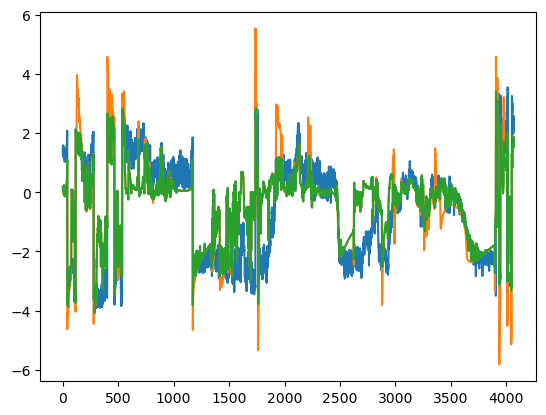

In [29]:
plt.plot(o)
plt.plot(p)
plt.plot(np.where(np.abs(o) < np.abs(p), o,p ))

In [36]:
(np.abs(o) < np.abs(p)).mean()

0.2910521140609636

In [39]:
better = []
history = []
for i in range(len(o)):
    history.append(abs(o[i]) < abs(p[i]))
    history = history[-10:]
    if np.mean(history) > .5:
        better.append(o[i])
    else:
        better.append(p[i])

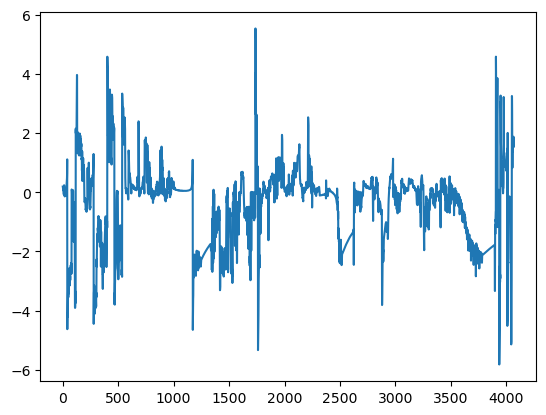

In [40]:
plt.plot(better)

## metrics

In [13]:
df = pd.DataFrame(brs).T

In [14]:
def f(br):
    lh_pred, lh_true, _ = br.get_behavior_last_half(br.obs_ds.time_offsets[-1])
    l = [np.corrcoef(np.squeeze([lh_pred[:,j], lh_true[:,j]]))[0,1] for j in range(lh_true.shape[1])]
    if len(l) < 4:
        pass
    else:
        l = [np.mean(l)]
    return ", ".join([str(round(x,2)) for x in l])

In [15]:
table = df.applymap(f)
table.loc["pred"] = df.applymap(lambda x: x.log_pred_p_summary(offset=1)).mean(axis=0)
table.loc["ent"] =  df.applymap(lambda x: x.entropy_summary(offset=1)).mean(axis=0)

In [16]:
table

,"s([obs,pos],6)","s(z([obs,pos]),4)","s(obs,6)",pos
"s(obs,6)",0.28,0.23,0.31,0.23
pos,"0.85, 0.9","0.86, 0.74","0.04, 0.48","0.99, 1.0"
hd,0.32,0.48,0.16,0.66
pred,-16.792315,-4.778438,-9.704904,-6.545597
ent,3.414309,2.494221,5.308792,0.518813


## Optimizing

In [22]:
datasets.keys()

dict_keys(['s(ca,6)', 's(vid,6)', 's([ca,s(vid,100)],6)'])

In [24]:
brs2 = []

In [41]:
%%time
brs2.append(evaluate(datasets['s([ca,s(vid,100)],6)'], datasets['s(vid,6)'], maxlen=20_000, 
                     bw_params=
                     dict(
                         num=100,
                         eps=1e-3, 
                         step=1,
                         num_grad_q=3,
                     )
                    )[0])

100%|███████████████████████████████████▉| 19998/19999 [00:22<00:00, 903.41it/s]


caching value in: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/simple_bw_run_168161473971125.pickle
retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/simple_bw_run_168161473971125.pickle
CPU times: user 2min 36s, sys: 2min 34s, total: 5min 11s
Wall time: 32.2 s


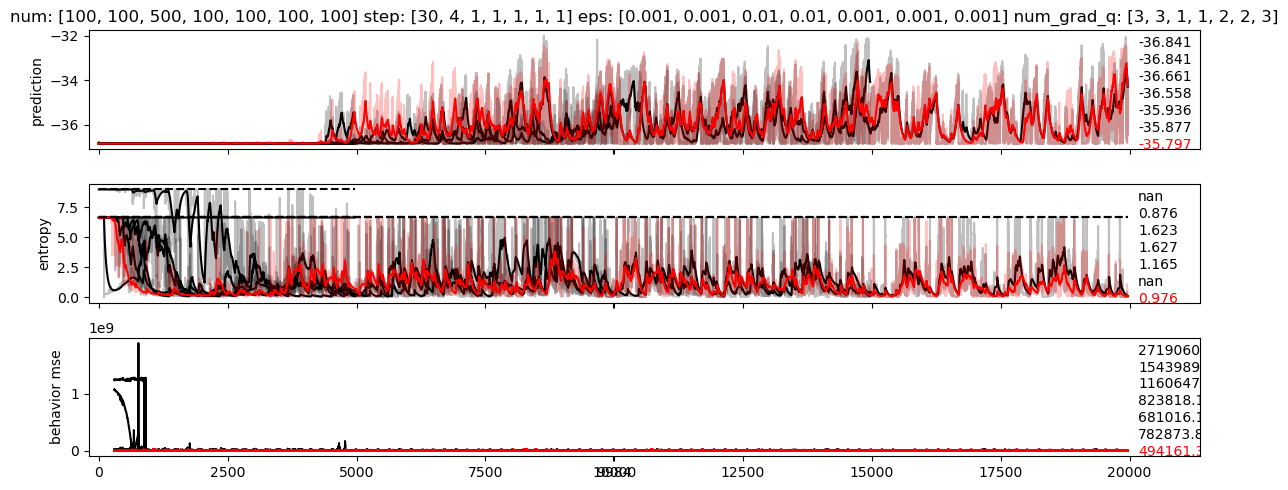

In [42]:
colors = ['k']*(len(brs2))
colors[-1] = 'r'
bpf.compare_metrics(brs2[-7:], colors=colors[-7:], offset=1, show_legend=False)

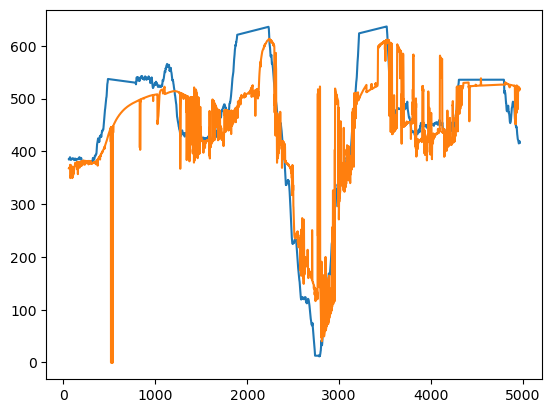

In [98]:
p = brs2[-1].behavior_pred_history[1]
e = brs2[-1].behavior_error_history[1]

t = p-e

plt.plot(t[:,0])
plt.plot(p[:,0])

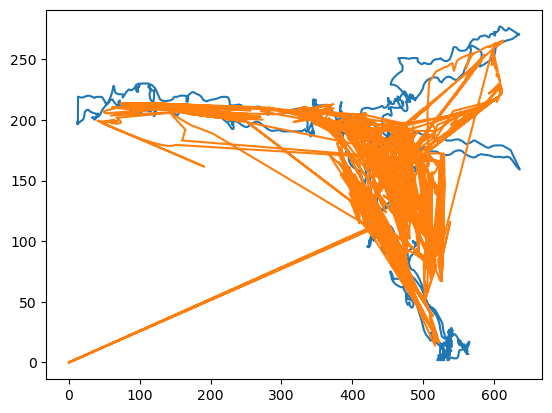

In [99]:
p = brs2[-1].behavior_pred_history[1]
e = brs2[-1].behavior_error_history[1]

t = p-e

plt.plot(t[:,0], t[:,1])
plt.plot(p[:,0], p[:,1])

# Compare Temporal Resolutions

In [ ]:
bin_widths = [.01, .03, .06]

fig, ax = plt.subplots(nrows=1, ncols=len(bin_widths), figsize=(14,4*1), layout='tight')

for idx, bin_width in enumerate(bin_widths):
    obs, raw_behavior, bin_centers, t = fin.construct_indy_data(fin.datasets["indy"][0])
    beh = fin.resample_behavior(raw_behavior, bin_centers, t)
    i = fin.prosvd_data(np.hstack([obs[10:], fin.zscore(beh, 10)]), 5, 20)
    o = fin.prosvd_data(beh, 1, 20)
    predicted, true = evaluate(i, o)
    predicted, true, t = fin.clip(predicted, true, t)
    
    mask = (800 < t) & (t < 860)
    ax[idx].plot(t[mask], true[mask])
    ax[idx].plot(t[mask], predicted[mask])
    ax[idx].set_title(f"{bin_width = }")

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=len(bin_widths), figsize=(14,4*1), layout='tight')

for idx, bin_width in enumerate(bin_widths):
    obs, raw_behavior, bin_centers, t = fin.construct_indy_data(fin.datasets["indy"][0])
    beh = fin.resample_behavior(raw_behavior, bin_centers, t)
    i = fin.prosvd_data(np.hstack([obs[10:], fin.zscore(beh, 10)]), 5, 20)
    o = fin.prosvd_data(beh, 1, 20)
    predicted, true = evaluate(i, o, auto_reg=True)
    predicted, true, t = fin.clip(predicted, true, t)
    
    mask = (800 < t) & (t < 860)
    ax[idx].plot(t[mask], true[mask])
    ax[idx].plot(t[mask], predicted[mask])
    ax[idx].set_title(f"{bin_width = }")

# Compare \alpha and \hat\alpha

In [ ]:
def do_regression(dataset, beh, method=1, nsteps=1, num=200):
    nsteps = 1
    alphas_shift = fin.bwrap_alphas_ahead(input_arr=dataset, bw_params=dict(bw.default_parameters.default_jpca_dataset_parameters, num=num), nsteps=nsteps)
    alphas_curr = fin.bwrap_alphas_ahead(input_arr=dataset, bw_params=dict(bw.default_parameters.default_jpca_dataset_parameters, num=num), nsteps=0)

    method = ['predicted current step', 'current step'][method]


    cut_beh = beh[-len(alphas_curr):]

    reg = bw.regressions.SymmetricNoisyRegressor(input_d=alphas_curr.shape[1], output_d=1)
    # reg = bw.regressions.NearestNeighborRegressor(input_d=alphas_curr.shape[1], output_d=1)
    preds = []
    cb = []
    for i in tqdm.tqdm(range(nsteps, len(alphas_curr)-2)):
        if method == 'predicted current step':
            reg.safe_observe(alphas_shift[i-nsteps], cut_beh[i])
        elif method == 'current step':
            reg.safe_observe(alphas_curr[i], cut_beh[i])


        preds.append(reg.predict(alphas_shift[i]))
        cb.append(cut_beh[i+nsteps])


    preds = np.squeeze(preds[np.nonzero(np.isfinite(preds))[0][0]:])[-1000:]
    cb = np.squeeze(cb)[-1000:]
    return preds, cb

In [ ]:
%matplotlib inline
fig, ax = plt.subplots()

p, t = do_regression(datasets['s3(z([s(neural), behavior]))'], datasets['z(behavior)'], method=1, num=60)

ax.plot(t)
ax.plot(p);
ax.set_xlabel('time')
ax.set_ylabel('synthetic behavior')
ax.set_title(f"Regression trained on $\\alpha$ ($R^2$ = {np.corrcoef(p,t)[0,1]:.2f})")
ax.legend(['true value (synthetic)', 'regressed value']);

In [ ]:
%matplotlib inline
fig, ax = plt.subplots()

p, t = do_regression(datasets['s3(z([s(neural), behavior]))'], datasets['z(behavior)'], method=0, num=60)

ax.plot(t)
ax.plot(p);
ax.set_xlabel('time')
ax.set_ylabel('synthetic behavior')
ax.set_title(f"Regression trained on $\\hat\\alpha$ ($R^2$ = {np.corrcoef(p,t)[0,1]:.2f})")
ax.legend(['true value (synthetic)', 'regressed value']);